#AAPP Challenge: Maze Generator with DisjointSet
Challenge for the first part of the course (Advanced Algorithm). \\

Developed by Sofia Martellozzo (10623060)

##Setup

In [ ]:
!apt install clang-10

Reading package lists... Done
Building dependency tree       
Reading state information... Done
clang-10 is already the newest version (1:10.0.0-4ubuntu1~18.04.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


Download the code

In [ ]:
!git clone https://github.com/google/benchmark.git
!git clone https://github.com/google/googletest.git benchmark/googletest

fatal: destination path 'benchmark' already exists and is not an empty directory.
fatal: destination path 'benchmark/googletest' already exists and is not an empty directory.


Organize the code and install

In [ ]:
!rm -rf benchmark/build
!cmake -E make_directory "benchmark/build"
!cmake -E chdir "benchmark/build" cmake -DBENCHMARK_DOWNLOAD_DEPENDENCIES=on -DCMAKE_BUILD_TYPE=Release ..
!cmake --build "benchmark/build" --config Release --target install

-- The CXX compiler identification is GNU 7.5.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Failed to find LLVM FileCheck
-- Found Git: /usr/bin/git (found version "2.17.1") 
-- git version: v1.7.0-24-g4eaa0c89 normalized to 1.7.0.24
-- Version: 1.7.0.24
-- Looking for shm_open in rt
-- Looking for shm_open in rt - found
-- Performing Test HAVE_CXX_FLAG_WALL
-- Performing Test HAVE_CXX_FLAG_WALL - Success
-- Performing Test HAVE_CXX_FLAG_WEXTRA
-- Performing Test HAVE_CXX_FLAG_WEXTRA - Success
-- Performing Test HAVE_CXX_FLAG_WSHADOW
-- Performing Test HAVE_CXX_FLAG_WSHADOW - Success
-- Performing Test HAVE_CXX_FLAG_WFLOAT_EQUAL
-- Performing Test HAVE_CXX_FLAG_WFLOAT_EQUAL - Success
-- Performing Test HAVE_CXX_FLAG_WERROR
-- Performing Test HAVE_CXX_FLAG_WERROR - Success
-- Performing Test HAVE_CXX_FLAG_PEDANTIC
-- Per

##Algorithm
- Generate the set of cells and walls 
- Use the disjoint-set data structure to compute the random maze
- Test the solution with Depth First Search algorithm

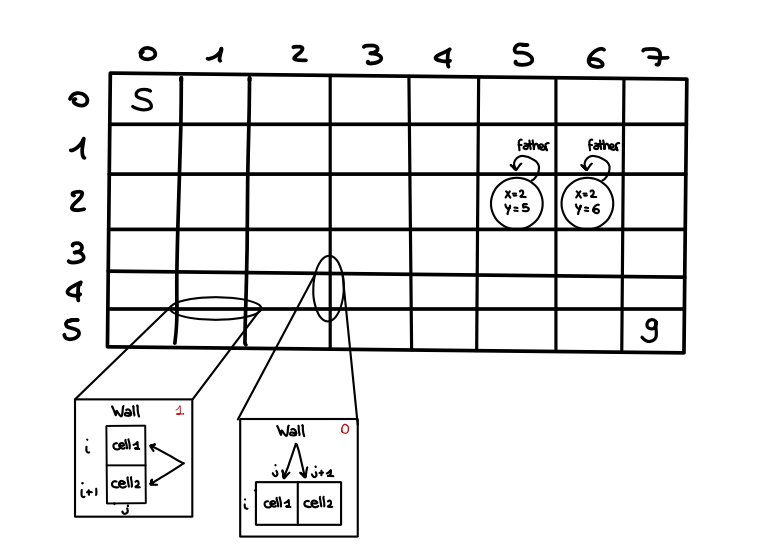

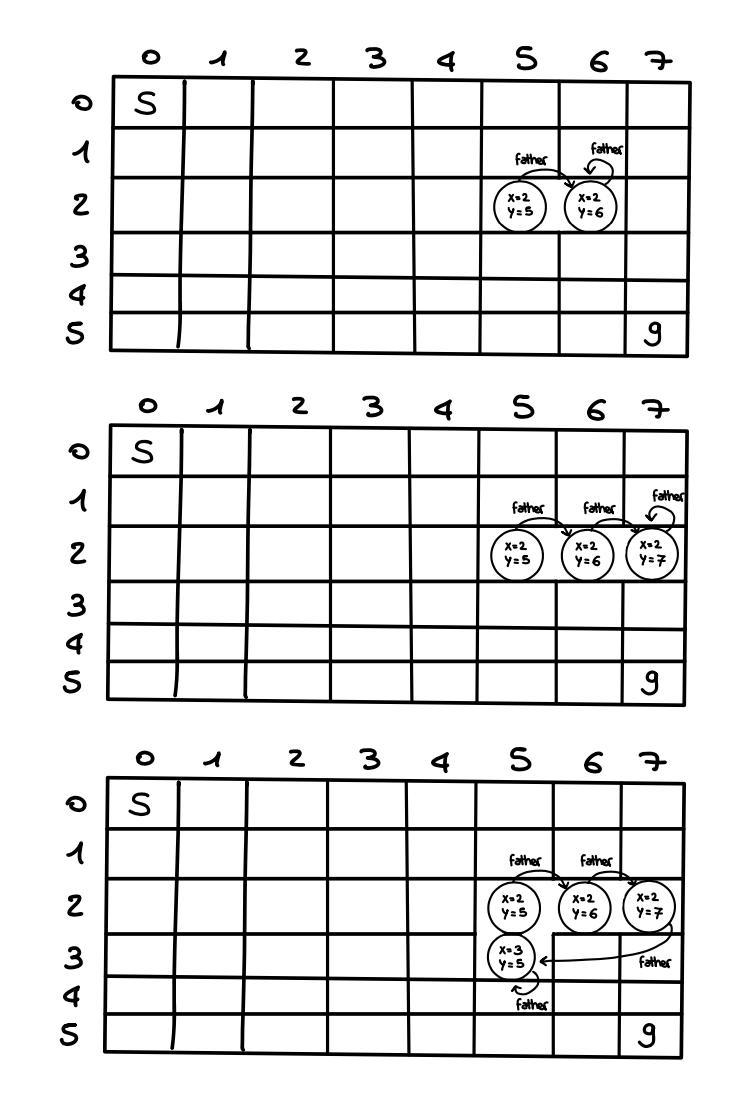

In [ ]:
%%writefile maze.cpp
#include <iostream> 
#include <list>
#include <random>
#include <algorithm>
using namespace std;


/* cell definition */
struct Cell {
  int x;                // column
  int y;                // row

  struct Cell *father;         // pointer to its father

  bool visited = false;        // marker for DFS 
  list<Cell* > adj_cells;      // adjacent list of cells (for DFS)

  bool Dx_wall = true;         // for representation
  bool Dw_wall = true; 
};

/* walls definition */
struct Walls{
  struct Cell *cell1;   // one side cell
  struct Cell *cell2;   // other side cell
  bool orientation;     // 0 = vertical 1 = orizontal
};

list<Cell* > sol;   // where DFS will store the path
list<Cell* > adj;   // where DFS will store the adjacent nodes


/* method to generate the grid with all the cells at the beguinning */
Cell** GenerateMaze(int num_rows,int num_cols){
  
  Cell **maze = new Cell *[num_rows];

  for(int i=0; i<num_rows; i++){

    maze[i] = new Cell[num_cols];
    for(int j=0; j<num_cols; j++){

      maze[i][j].x = i;
      maze[i][j].y = j;
      maze[i][j].father = &maze[i][j]; //at first each set is comosed of only the cell itself
    }
  }
  return maze;
}

/* method to initialize all the walls in the grid at the beguinning */
list<Walls> GenerateWalls(int num_rows, int num_cols, Cell** maze){

  list<Walls> walls;

  for(int i=0; i<num_rows; i++){
    for(int j=0; j<num_cols; j++){
      if(j<num_cols-1) {
        
        Walls wall1;
        wall1.cell1 = &maze[i][j];
        wall1.cell2 = &maze[i][j+1]; // dx
        wall1.orientation = 0;       // vertical
        walls.push_back(wall1);
        
      };
      if(i<num_rows-1) {
        
        Walls wall2;
        wall2.cell1 = &maze[i][j];
        wall2.cell2 = &maze[i+1][j]; // down
        wall2.orientation = 1;       // orizontal
        walls.push_back(wall2);
      
      };
    }
  }
  return walls;
}

/* recursive method to find the representative of the cell given in input */
Cell* Find_Set(Cell *c){

    if ((c->x == c->father->x)&&(c->y == c->father->y)){
        //we found the representative
        return c;
    }
    else{
        //go up on the tree
        Cell * aux_pointer;
        aux_pointer = Find_Set(c->father);
        return aux_pointer;
    }
}

/* method to verify if the cells given as input belongs to the same set (= have the same representative) */
bool Find(Cell *c1, Cell *c2){

  Cell *father1;
  Cell *father2;

  father1 = Find_Set(c1);
  father2 = Find_Set(c2);

  if ((father1->x == father2->x)&&(father1->y == father2->y)){
    return true;
  }
  else{
    return false;
  }
}

/* method to join to cell in the same set
  if them already belongs to two different sets, join these two */
void Union (Cell *c1, Cell *c2){

  Cell *aux_father1;
  Cell *aux_father2;

  aux_father1 = Find_Set(c1);
  aux_father2 = Find_Set(c2);

  aux_father1->father = aux_father2;

  c1->adj_cells.push_back(c2);  // set the near by reference for the visualization
  c2->adj_cells.push_back(c1);

}

/* Depth First Search Algorithm to find the path from s to g */
list<Cell* > DFS(Cell  *node, Cell  *goal){

  sol.push_back(node);
  node->visited = true;
  if(adj.size() > 0){

    adj.remove(node);        //remove the first element 
  }
  
  if((node->x == goal->x)&&(node->y == goal->y)){

    cout << "(" << node->x << "," << node->y << ") " << endl;
    return sol;
  }
  else{

    // debug
    cout << "(" << node->x << "," << node->y << ") -> ";

    list<Cell* > node_adj;
    node_adj = node->adj_cells; 

    for(auto it = node_adj.begin(); it != node_adj.end(); ++it){
        
        Cell* c = (*it);
        if(c->visited == false){
            
            adj.push_front(*it);
        }
    }
    Cell * new_node;
    new_node = adj.front();
    sol = DFS(new_node, goal);

    return sol;
  }
}

void PrintMaze(int num_cols, int num_rows, Cell ** maze){
  string roof;
  roof += " ";
  string one_roof = "__";
  for (int i = 0; i < num_cols; i++){
    roof += one_roof;
  }

  cout << roof << endl;

  for(int r = 0; r < num_rows; r++){
    string row;
    row += "|";
    for(int c = 0; c < num_cols; c++){
      if (maze[r][c].Dx_wall){
        if(maze[r][c].Dw_wall){
          row += "_|";
        }
        else{
          row += " |";
        }
        
      }
      else if(maze[r][c].Dw_wall){
        row += "_ ";
      }
      else{
        row += "  ";
      }
    }
    cout << row << endl;
  }
}

bool contains(list<Cell* > l, Cell* c){
  return std::find(std::begin(l),std::end(l),c) != std::end(l);
}

void PrintPath(int num_cols, int num_rows, Cell ** maze, list<Cell* > path){
  string roof;
  roof += " ";
  string one_roof = "___";
  for (int i = 0; i < num_cols; i++){
    roof += one_roof;
  }

  cout << roof << endl;

  bool exists ;

  for(int r = 0; r < num_rows; r++){
    string row;
    row += "|";
    for(int c = 0; c < num_cols; c++){

      exists = contains(path, &maze[r][c]); //check if current cell is in the path

      if(!exists){
        if (maze[r][c].Dx_wall){
          if(maze[r][c].Dw_wall){
            row += "__|";
          }
          else{
            row += "  |";
          }
            
        }
        else if(maze[r][c].Dw_wall){
          row += "__ ";
        }
        else{
          row += "   ";
        }
      }
      else{
        if (maze[r][c].Dx_wall){
          if(maze[r][c].Dw_wall){
            row += "x_|";
          }
          else{
            row += "x |";
          }
            
        }
        else if(maze[r][c].Dw_wall){
          row += "x_ ";
        }
        else{
          row += "x  ";
        }

      }

    }
    cout << row << endl;
  }
}



int main(){

  int num_cols = 8;
  int num_rows = 6;

  // generate the grid of all cells
  Cell **maze;
  maze = GenerateMaze(num_rows, num_cols);

  // generate the list of walls
  list<Walls> walls;
  walls = GenerateWalls(num_rows, num_cols, maze);
  
  Cell  *start = &maze[0][0];
  Cell  *goal = &maze[num_rows-1][num_cols-1];

  // repeat until s and g are in the same set
  while(!Find(start, goal)){

    int walls_lenght = walls.size();

    std::random_device rd;     // Only used once to initialise (seed) engine
    std::mt19937 rng(rd());    // Random-number engine used (Mersenne-Twister in this case)
    std::uniform_int_distribution<int> uni(1,walls_lenght); // Guaranteed unbiased
    auto random_integer = uni(rng);

    cout << "random number: " << random_integer << endl;

    // initialize iterator to list
    list<Walls>::iterator it = walls.begin();
    //move the iterator by random_integer -1 elements, -1 because the list starts from 0
    advance(it, random_integer - 1);

    cout << "(" << it->cell1->x << "," << it->cell1->y << ") ";
    cout << "(" << it->cell2->x << "," << it->cell2->y << ") : ";

    // get the two cell faced by the wall selected
    Cell *neighbor1 = it->cell1;
    Cell *neighbor2 = it->cell2;

    // check if belongs to the same set
    if(!Find(neighbor1, neighbor2)){

      cout << "remove wall" << endl;

      if(it->orientation == 0){
        //vertical wall removed
        neighbor1->Dx_wall = false;
      }
      else{
        //orizontal
        neighbor1->Dw_wall = false;
      }

      // join the two cell in the same set
      Union(neighbor1, neighbor2);

      PrintMaze(num_cols, num_rows, maze);

    }
    else{
      cout << "do not remove the wall" << endl;
      PrintMaze(num_cols, num_rows, maze);
    }
    walls.erase(it);  // remove the wall from the list
  }

  cout << "Path foud with DFS: " << endl;

  list<Cell* > path ;  // the path from s to g
  path = DFS(start, goal);

  //now print the final solution
  PrintMaze(num_cols, num_rows, maze);
  PrintPath(num_cols, num_rows, maze, path);

  return 0;
  
}





Overwriting maze.cpp


In [ ]:
!clang++-10 maze.cpp -O2 -std=c++2a -isystem benchmark/include -Lbenchmark/build/src -lbenchmark -lpthread -o maze -g

In [ ]:
!./maze

random number: 65
(4,2) (4,3) : remove wall
 ________________
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_ _|_|_|_|_|
|_|_|_|_|_|_|_|_|
random number: 70
(4,5) (4,6) : remove wall
 ________________
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_ _|_|_ _|_|
|_|_|_|_|_|_|_|_|
random number: 60
(3,7) (4,7) : remove wall
 ________________
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_| |
|_|_|_ _|_|_ _|_|
|_|_|_|_|_|_|_|_|
random number: 2
(0,0) (1,0) : remove wall
 ________________
| |_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_| |
|_|_|_ _|_|_ _|_|
|_|_|_|_|_|_|_|_|
random number: 40
(2,5) (2,6) : remove wall
 ________________
| |_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_ _|_|
|_|_|_|_|_|_|_| |
|_|_|_ _|_|_ _|_|
|_|_|_|_|_|_|_|_|
random number: 72
(5,1) (5,2) : remove wall
 ________________
| |_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_ _|_|
|_|_|_|_|_|_|_| |
|_|_|_ _|_|_ _|_|

Version of the code to use the benchmark. \\
The verification (DFS) and the print of the solution are not performed here.

In [ ]:
%%writefile maze_test.cpp
#include <benchmark/benchmark.h>
#include <iostream> 
#include <list>
#include <random>
#include <algorithm>
using namespace std;


/* cell definition */
struct Cell {
  int x;                // column
  int y;                // row

  struct Cell *father;         // pointer to its father

  bool visited = false;        // marker for DFS 
  list<Cell* > adj_cells;      // adjacent list of cells (for DFS)

  bool Dx_wall = true;         // for representation
  bool Dw_wall = true; 
};

/* walls definition */
struct Walls{
  struct Cell *cell1;   // one side cell
  struct Cell *cell2;   // other side cell
  bool orientation;     // 0 = vertical 1 = orizontal
};

list<Cell* > sol;   // where DFS will store the path
list<Cell* > adj;   // where DFS will store the adjacent nodes


/* method to generate the grid with all the cells at the beguinning */
Cell** GenerateMaze(int num_rows,int num_cols){
  
  Cell **maze = new Cell *[num_rows];

  for(int i=0; i<num_rows; i++){

    maze[i] = new Cell[num_cols];
    for(int j=0; j<num_cols; j++){

      maze[i][j].x = i;
      maze[i][j].y = j;
      maze[i][j].father = &maze[i][j]; //at first each set is comosed of only the cell itself
    }
  }
  return maze;
}

/* method to initialize all the walls in the grid at the beguinning */
list<Walls> GenerateWalls(int num_rows, int num_cols, Cell** maze){

  list<Walls> walls;

  for(int i=0; i<num_rows; i++){
    for(int j=0; j<num_cols; j++){
      if(j<num_cols-1) {
        
        Walls wall1;
        wall1.cell1 = &maze[i][j];
        wall1.cell2 = &maze[i][j+1]; // dx
        wall1.orientation = 0;       // vertical
        walls.push_back(wall1);
        
      };
      if(i<num_rows-1) {
        
        Walls wall2;
        wall2.cell1 = &maze[i][j];
        wall2.cell2 = &maze[i+1][j]; // down
        wall2.orientation = 1;       // orizontal
        walls.push_back(wall2);
      
      };
    }
  }
  return walls;
}

/* recursive method to find the representative of the cell given in input */
Cell* Find_Set(Cell *c){

    if ((c->x == c->father->x)&&(c->y == c->father->y)){
        //we found the representative
        return c;
    }
    else{
        //go up on the tree
        Cell * aux_pointer;
        aux_pointer = Find_Set(c->father);
        return aux_pointer;
    }
}

/* method to verify if the cells given as input belongs to the same set (= have the same representative) */
bool Find(Cell *c1, Cell *c2){

  Cell *father1;
  Cell *father2;

  father1 = Find_Set(c1);
  father2 = Find_Set(c2);

  if ((father1->x == father2->x)&&(father1->y == father2->y)){
    return true;
  }
  else{
    return false;
  }
}

/* method to join to cell in the same set
  if them already belongs to two different sets, join these two */
void Union (Cell *c1, Cell *c2){

  Cell *aux_father1;
  Cell *aux_father2;

  aux_father1 = Find_Set(c1);
  aux_father2 = Find_Set(c2);

  aux_father1->father = aux_father2;

  c1->adj_cells.push_back(c2);
  c2->adj_cells.push_back(c1);

}
void aux_main(int cols, int rows, Cell **maze2, list<Walls> walls2){

  int num_cols = cols;
  int num_rows = rows;
  Cell **maze;
  maze = maze2;
  list<Walls> walls;
  walls = walls2;
  
  Cell  *start = &maze[0][0];
  Cell  *goal = &maze[num_rows-1][num_cols-1];

  // repeat until s and g are in the same set
  while(!Find(start, goal)){

    int walls_lenght = walls.size();
    
    std::random_device rd;     // Only used once to initialise (seed) engine
    std::mt19937 rng(rd());    // Random-number engine used (Mersenne-Twister in this case)
    std::uniform_int_distribution<int> uni(1,walls_lenght); // Guaranteed unbiased
    auto random_integer = uni(rng);

    // initialize iterator to list
    list<Walls>::iterator it = walls.begin();
    //move the iterator by random_integer -1 elements, -1 because the list starts from 0
    advance(it, random_integer - 1);

    // get the two cell faced by the wall selected
    Cell *neighbor1 = it->cell1;
    Cell *neighbor2 = it->cell2;

    // check if belongs to the same set
    if(!Find(neighbor1, neighbor2)){

      // join the two cell in the same set
      Union(neighbor1, neighbor2);
    }
    walls.erase(it);  // remove the wall from the list
  }
}

static void BM_main(benchmark::State& state){
  
  int cols = state.range(0);
  int rows = state.range(0);

  // generate the grid of all cells
  Cell **maze;
  maze = GenerateMaze(rows, cols);

  // generate the list of walls
  list<Walls> walls;
  walls = GenerateWalls(rows, cols, maze);

  for (auto _ : state) {
    aux_main(cols, rows, maze, walls);
  }
  state.SetComplexityN(state.range(0));
}

BENCHMARK (BM_main)
  ->RangeMultiplier(2)
  ->Range(2,128)
  ->Complexity();

BENCHMARK_MAIN();


Overwriting maze_test.cpp


In [ ]:
!clang++-10 maze_test.cpp -O2 -std=c++2a -isystem benchmark/include -Lbenchmark/build/src -lbenchmark -lpthread -o maze_test 

In [ ]:
!./maze_test

2022-10-20T10:17:23+00:00
Running ./maze_test
Run on (2 X 2200 MHz CPU s)
CPU Caches:
  L1 Data 32 KiB (x1)
  L1 Instruction 32 KiB (x1)
  L2 Unified 256 KiB (x1)
  L3 Unified 56320 KiB (x1)
Load Average: 0.95, 0.58, 0.45
------------------------------------------------------
Benchmark            Time             CPU   Iterations
------------------------------------------------------
BM_main/2          133 ns          132 ns      4913424
BM_main/4          774 ns          765 ns       908227
BM_main/8         3441 ns         3409 ns       209992
BM_main/16       14823 ns        14690 ns        46033
BM_main/32       64399 ns        64202 ns         9391
BM_main/64      640782 ns       638475 ns          990
BM_main/128 1504694883 ns   1491202229 ns            1
BM_main_BigO     706.32 N^3      699.99 N^3  
BM_main_RMS         33 %            33 %    


##Second version of the Algorithm
Perform an optimization by updatin the new father of also a child of a node and the node itself (if its father is not itself)

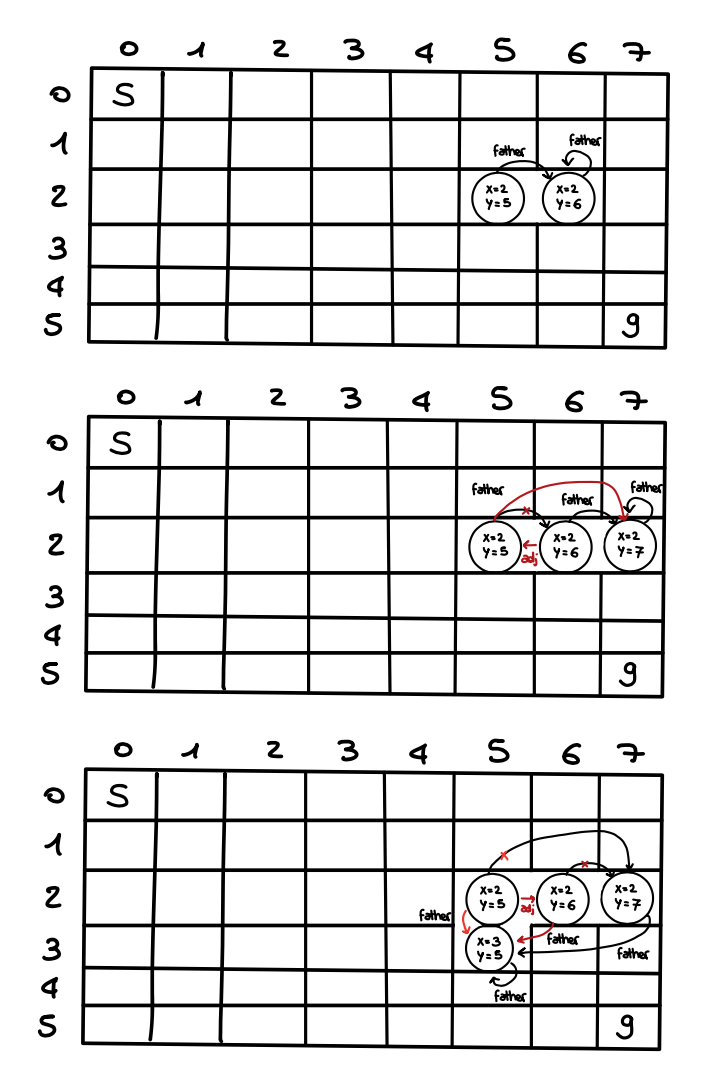

In [ ]:
%%writefile maze2.cpp
#include <iostream> 
#include <list>
#include <random>
#include <algorithm>
using namespace std;


/* cell definition */
struct Cell {
  int x;                // column
  int y;                // row

  struct Cell *father;         // pointer to its father

  bool visited = false;        // marker for DFS 
  list<Cell* > adj_cells;      // adjacent list of cells (for DFS)

  bool Dx_wall = true;         // for representation
  bool Dw_wall = true; 
};

/* walls definition */
struct Walls{
  struct Cell *cell1;   // one side cell
  struct Cell *cell2;   // other side cell
  bool orientation;     // 0 = vertical 1 = orizontal
};

list<Cell* > sol;
list<Cell* > adj;


/* method to generate the grid with all the cells at the beguinning */
Cell** GenerateMaze(int num_rows,int num_cols){
  
  Cell **maze = new Cell *[num_rows];

  for(int i=0; i<num_rows; i++){

    maze[i] = new Cell[num_cols];
    for(int j=0; j<num_cols; j++){

      maze[i][j].x = i;
      maze[i][j].y = j;
      maze[i][j].father = &maze[i][j]; //at first each set is comosed of only the cell itself
    }
  }
  return maze;
}

/* method to initialize all the walls in the grid at the beguinning */
list<Walls> GenerateWalls(int num_rows, int num_cols, Cell** maze){

  list<Walls> walls;

  for(int i=0; i<num_rows; i++){
    for(int j=0; j<num_cols; j++){
      if(j<num_cols-1) {
        
        Walls wall1;
        wall1.cell1 = &maze[i][j];
        wall1.cell2 = &maze[i][j+1]; // dx
        wall1.orientation = 0;       // vertical
        walls.push_back(wall1);
        
      };
      if(i<num_rows-1) {
        
        Walls wall2;
        wall2.cell1 = &maze[i][j];
        wall2.cell2 = &maze[i+1][j]; // down
        wall2.orientation = 1;       // orizontal
        walls.push_back(wall2);
      
      };
    }
  }
  return walls;
}

/* recursive method to find the representative of the cell given in input */
Cell* Find_Set(Cell *c){

    if ((c->x == c->father->x)&&(c->y == c->father->y)){
        //we found the representative
        return c;
    }
    else{
        //go up on the tree
        Cell * aux_pointer;
        aux_pointer = Find_Set(c->father);
        return aux_pointer;
    }
}

/* method to verify if the cells given as input belongs to the same set (= have the same representative) */
bool Find(Cell *c1, Cell *c2){

  Cell *father1;
  Cell *father2;

  father1 = Find_Set(c1);
  father2 = Find_Set(c2);

  if ((father1->x == father2->x)&&(father1->y == father2->y)){
    return true;
  }
  else{
    return false;
  }
}

/* method to join to cell in the same set
  if them already belongs to two different sets, join these two */
void Union (Cell *c1, Cell *c2){

  Cell *aux_father1;
  Cell *aux_father2;

  aux_father1 = Find_Set(c1);
  aux_father2 = Find_Set(c2);

  aux_father1->father = aux_father2;

  //update itself if its father is not itself
  if((c1->x != aux_father1->x)||(c1->y != aux_father1->y)){
    c1->father = aux_father2;
  }
  //update also father of a child
  if(!c1->adj_cells.empty()){
    (*c1->adj_cells.begin())->father = aux_father2;

  }

  c1->adj_cells.push_back(c2);
  c2->adj_cells.push_back(c1);

}

/* Depth First Search Algorithm to find the path from s to g */
list<Cell* > DFS(Cell  *node, Cell  *goal){

  sol.push_back(node);
  node->visited = true;
  if(adj.size() > 0){

    adj.remove(node);        //remove the first element 
  }
  
  if((node->x == goal->x)&&(node->y == goal->y)){

    cout << "(" << node->x << "," << node->y << ") " << endl;
    return sol;
  }
  else{

    cout << "(" << node->x << "," << node->y << ") -> ";

    list<Cell* > node_adj;
    node_adj = node->adj_cells; 

    for(auto it = node_adj.begin(); it != node_adj.end(); ++it){
        
        Cell* c = (*it);
        if(c->visited == false){
            
            adj.push_front(*it);
        }
    }
    Cell * new_node;
    new_node = adj.front();
    sol = DFS(new_node, goal);

    return sol;
  }
}

void PrintMaze(int num_cols, int num_rows, Cell ** maze){
  string roof;
  roof += " ";
  string one_roof = "__";
  for (int i = 0; i < num_cols; i++){
    roof += one_roof;
  }

  cout << roof << endl;

  for(int r = 0; r < num_rows; r++){
    string row;
    row += "|";
    for(int c = 0; c < num_cols; c++){
      if (maze[r][c].Dx_wall){
        if(maze[r][c].Dw_wall){
          row += "_|";
        }
        else{
          row += " |";
        }
        
      }
      else if(maze[r][c].Dw_wall){
        row += "_ ";
      }
      else{
        row += "  ";
      }
    }
    cout << row << endl;
  }
}


bool contains(list<Cell* > l, Cell* c){
  return std::find(std::begin(l),std::end(l),c) != std::end(l);
}

void PrintPath(int num_cols, int num_rows, Cell ** maze, list<Cell* > path){
  string roof;
  roof += " ";
  string one_roof = "___";
  for (int i = 0; i < num_cols; i++){
    roof += one_roof;
  }

  cout << roof << endl;

  bool exists ;

  for(int r = 0; r < num_rows; r++){
    string row;
    row += "|";
    for(int c = 0; c < num_cols; c++){

      exists = contains(path, &maze[r][c]); //check if current cell is in the path

      if(!exists){
        if (maze[r][c].Dx_wall){
          if(maze[r][c].Dw_wall){
            row += "__|";
          }
          else{
            row += "  |";
          }
            
        }
        else if(maze[r][c].Dw_wall){
          row += "__ ";
        }
        else{
          row += "   ";
        }
      }
      else{
        if (maze[r][c].Dx_wall){
          if(maze[r][c].Dw_wall){
            row += "x_|";
          }
          else{
            row += "x |";
          }
            
        }
        else if(maze[r][c].Dw_wall){
          row += "x_ ";
        }
        else{
          row += "x  ";
        }

      }

    }
    cout << row << endl;
  }
}



int main(){

  int num_cols = 8;
  int num_rows = 6;

  // generate the grid of all cells
  Cell **maze;
  maze = GenerateMaze(num_rows, num_cols);

  // generate the list of walls
  list<Walls> walls;
  walls = GenerateWalls(num_rows, num_cols, maze);
  
  Cell  *start = &maze[0][0];
  Cell  *goal = &maze[num_rows-1][num_cols-1];

  // repeat until s and g are in the same set
  while(!Find(start, goal)){

    int walls_lenght = walls.size();
    
    std::random_device rd;     // Only used once to initialise (seed) engine
    std::mt19937 rng(rd());    // Random-number engine used (Mersenne-Twister in this case)
    std::uniform_int_distribution<int> uni(1,walls_lenght); // Guaranteed unbiased
    auto random_integer = uni(rng);

    cout << "random number: " << random_integer << endl;

    // initialize iterator to list
    list<Walls>::iterator it = walls.begin();
    //move the iterator by random_integer -1 elements, -1 because the list starts from 0
    advance(it, random_integer - 1);

    cout << "(" << it->cell1->x << "," << it->cell1->y << ") ";
    cout << "(" << it->cell2->x << "," << it->cell2->y << ") : ";

    // get the two cell faced by the wall selected
    Cell *neighbor1 = it->cell1;
    Cell *neighbor2 = it->cell2;

    // check if belongs to the same set
    if(!Find(neighbor1, neighbor2)){

      cout << "remove wall" << endl;

      if(it->orientation == 0){
        //vertical wall removed
        neighbor1->Dx_wall = false;
      }
      else{
        //orizontal
        neighbor1->Dw_wall = false;
      }

      // join the two cell in the same set
      Union(neighbor1, neighbor2);

      PrintMaze(num_cols, num_rows, maze);
    }
    else{
      cout << "do not remove the wall" << endl;
      PrintMaze(num_cols, num_rows, maze);
    }
    walls.erase(it);  // remove the wall from the list
  }

  cout << "Path foud with DFS: " << endl;

  list<Cell* > path ;  // the path from s to g
  path = DFS(start, goal);

  //now print the final solution
  PrintMaze(num_cols, num_rows, maze);
  PrintPath(num_cols, num_rows, maze, path);

  return 0;
  
}





Overwriting maze2.cpp


In [ ]:
!clang++-10 maze2.cpp -O2 -std=c++2a -isystem benchmark/include -Lbenchmark/build/src -lbenchmark -lpthread -o maze2 -g

In [ ]:
!./maze2

random number: 38
(2,3) (3,3) : remove wall
 ________________
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_| |_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
random number: 63
(4,1) (5,1) : remove wall
 ________________
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_| |_|_|_|_|
|_|_|_|_|_|_|_|_|
|_| |_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
random number: 17
(1,0) (2,0) : remove wall
 ________________
|_|_|_|_|_|_|_|_|
| |_|_|_|_|_|_|_|
|_|_|_| |_|_|_|_|
|_|_|_|_|_|_|_|_|
|_| |_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
random number: 66
(4,4) (4,5) : remove wall
 ________________
|_|_|_|_|_|_|_|_|
| |_|_|_|_|_|_|_|
|_|_|_| |_|_|_|_|
|_|_|_|_|_|_|_|_|
|_| |_|_|_ _|_|_|
|_|_|_|_|_|_|_|_|
random number: 11
(0,5) (0,6) : remove wall
 ________________
|_|_|_|_|_|_ _|_|
| |_|_|_|_|_|_|_|
|_|_|_| |_|_|_|_|
|_|_|_|_|_|_|_|_|
|_| |_|_|_ _|_|_|
|_|_|_|_|_|_|_|_|
random number: 46
(3,1) (4,1) : remove wall
 ________________
|_|_|_|_|_|_ _|_|
| |_|_|_|_|_|_|_|
|_|_|_| |_|_|_|_|
|_| |_|_|_|_|_|_|
|_| |_|_|_ _|_|_

In [ ]:
%%writefile maze_test2.cpp
#include <benchmark/benchmark.h>
#include <iostream> 
#include <list>
#include <random>
#include <algorithm>
using namespace std;


/* cell definition */
struct Cell {
  int x;                // column
  int y;                // row

  struct Cell *father;         // pointer to its father

  bool visited = false;        // marker for DFS 
  list<Cell* > adj_cells;      // adjacent list of cells (for DFS)

  bool Dx_wall = true;         // for representation
  bool Dw_wall = true; 
};

/* walls definition */
struct Walls{
  struct Cell *cell1;   // one side cell
  struct Cell *cell2;   // other side cell
  bool orientation;     // 0 = vertical 1 = orizontal
};

list<Cell* > sol;
list<Cell* > adj;


/* method to generate the grid with all the cells at the beguinning */
Cell** GenerateMaze(int num_rows,int num_cols){
  
  Cell **maze = new Cell *[num_rows];

  for(int i=0; i<num_rows; i++){

    maze[i] = new Cell[num_cols];
    for(int j=0; j<num_cols; j++){

      maze[i][j].x = i;
      maze[i][j].y = j;
      maze[i][j].father = &maze[i][j]; //at first each set is comosed of only the cell itself
    }
  }
  return maze;
}

/* method to initialize all the walls in the grid at the beguinning */
list<Walls> GenerateWalls(int num_rows, int num_cols, Cell** maze){

  list<Walls> walls;

  for(int i=0; i<num_rows; i++){
    for(int j=0; j<num_cols; j++){
      if(j<num_cols-1) {
        
        Walls wall1;
        wall1.cell1 = &maze[i][j];
        wall1.cell2 = &maze[i][j+1]; // dx
        wall1.orientation = 0;       // orizontal
        walls.push_back(wall1);
        
      };
      if(i<num_rows-1) {
        
        Walls wall2;
        wall2.cell1 = &maze[i][j];
        wall2.cell2 = &maze[i+1][j]; // down
        wall2.orientation = 1;       // vertical
        walls.push_back(wall2);
      
      };
    }
  }
  return walls;
}

/* recursive method to find the representative of the cell given in input */
Cell* Find_Set(Cell *c){

    if ((c->x == c->father->x)&&(c->y == c->father->y)){
        //we found the representative
        return c;
    }
    else{
        //go up on the tree
        Cell * aux_pointer;
        aux_pointer = Find_Set(c->father);
        return aux_pointer;
    }
}

/* method to verify if the cells given as input belongs to the same set (= have the same representative) */
bool Find(Cell *c1, Cell *c2){

  Cell *father1;
  Cell *father2;

  father1 = Find_Set(c1);
  father2 = Find_Set(c2);

  if ((father1->x == father2->x)&&(father1->y == father2->y)){
    return true;
  }
  else{
    return false;
  }
}

/* method to join to cell in the same set
  if them already belongs to two different sets, join these two */
void Union (Cell *c1, Cell *c2){

  Cell *aux_father1;
  Cell *aux_father2;

  aux_father1 = Find_Set(c1);
  aux_father2 = Find_Set(c2);

  aux_father1->father = aux_father2;

  //update itself if its father is not itself
  if((c1->x != aux_father1->x)||(c1->y != aux_father1->y)){
    c1->father = aux_father2;
  }
  
  //update also father of a child
  if(!c1->adj_cells.empty()){
    (*c1->adj_cells.begin())->father = aux_father2;

  }

  c1->adj_cells.push_back(c2);
  c2->adj_cells.push_back(c1);

}
void aux_main(int cols, int rows, Cell **maze2, list<Walls> walls2){

  int num_cols = cols;
  int num_rows = rows;
  Cell **maze;
  maze = maze2;
  list<Walls> walls;
  walls = walls2;
  
  Cell  *start = &maze[0][0];
  Cell  *goal = &maze[num_rows-1][num_cols-1];

  // repeat until s and g are in the same set
  while(!Find(start, goal)){

    // debug
    int walls_lenght = walls.size();
    
    std::random_device rd;     // Only used once to initialise (seed) engine
    std::mt19937 rng(rd());    // Random-number engine used (Mersenne-Twister in this case)
    std::uniform_int_distribution<int> uni(1,walls_lenght); // Guaranteed unbiased
    auto random_integer = uni(rng);

    // initialize iterator to list
    list<Walls>::iterator it = walls.begin();
    //move the iterator by random_integer -1 elements, -1 because the list starts from 0
    advance(it, random_integer - 1);

    // get the two cell faced by the wall selected
    Cell *neighbor1 = it->cell1;
    Cell *neighbor2 = it->cell2;

    // check if belongs to the same set
    if(!Find(neighbor1, neighbor2)){

      // join the two cell in the same set
      Union(neighbor1, neighbor2);
    }
    walls.erase(it);  // remove the wall from the list
  }
}

static void BM_main(benchmark::State& state){
  
  int cols = state.range(0);
  int rows = state.range(0);

  // generate the grid of all cells
  Cell **maze;
  maze = GenerateMaze(rows, cols);

  // generate the list of walls
  list<Walls> walls;
  walls = GenerateWalls(rows, cols, maze);

  for (auto _ : state) {
    aux_main(cols, rows, maze, walls);
  }
  state.SetComplexityN(state.range(0));
}

BENCHMARK (BM_main)
  ->RangeMultiplier(2)
  ->Range(2,128)
  ->Complexity();

BENCHMARK_MAIN();


Overwriting maze_test2.cpp


In [ ]:
!clang++-10 maze_test2.cpp -O2 -std=c++2a -isystem benchmark/include -Lbenchmark/build/src -lbenchmark -lpthread -o maze_test2 

In [ ]:
!./maze_test2

2022-10-20T10:17:33+00:00
Running ./maze_test2
Run on (2 X 2200 MHz CPU s)
CPU Caches:
  L1 Data 32 KiB (x1)
  L1 Instruction 32 KiB (x1)
  L2 Unified 256 KiB (x1)
  L3 Unified 56320 KiB (x1)
Load Average: 0.96, 0.59, 0.45
------------------------------------------------------
Benchmark            Time             CPU   Iterations
------------------------------------------------------
BM_main/2          132 ns          131 ns      5245268
BM_main/4          758 ns          753 ns       865382
BM_main/8         3271 ns         3255 ns       206684
BM_main/16       15167 ns        14991 ns        48967
BM_main/32       65033 ns        64966 ns         9740
BM_main/64      630435 ns       629502 ns          900
BM_main/128 1188528862 ns   1187568869 ns            1
BM_main_BigO     557.92 N^3      557.47 N^3  
BM_main_RMS         33 %            33 %    


##Algorithm with Path Compression
Add the update of the father (representative) in the Find_Set function to optimize the algorithm

In [ ]:
%%writefile maze3.cpp

#include <iostream> 
#include <list>
#include <random>
#include <algorithm>
using namespace std;


/* cell definition */
struct Cell {
  int x;                // column
  int y;                // row

  struct Cell *father;         // pointer to its father

  bool visited = false;        // marker for DFS 
  list<Cell* > adj_cells;      // adjacent list of cells (for DFS)

  bool Dx_wall = true;         // for representation
  bool Dw_wall = true; 
};

/* walls definition */
struct Walls{
  struct Cell *cell1;   // one side cell
  struct Cell *cell2;   // other side cell
  bool orientation;     // 0 = vertical 1 = orizontal
};

list<Cell* > sol;   // where DFS will store the path
list<Cell* > adj;   // where DFS will store the adjacent nodes


/* method to generate the grid with all the cells at the beguinning */
Cell** GenerateMaze(int num_rows,int num_cols){
  
  Cell **maze = new Cell *[num_rows];

  for(int i=0; i<num_rows; i++){

    maze[i] = new Cell[num_cols];
    for(int j=0; j<num_cols; j++){

      maze[i][j].x = i;
      maze[i][j].y = j;
      maze[i][j].father = &maze[i][j]; //at first each set is comosed of only the cell itself
    }
  }
  return maze;
}

/* method to initialize all the walls in the grid at the beguinning */
list<Walls> GenerateWalls(int num_rows, int num_cols, Cell** maze){

  list<Walls> walls;

  for(int i=0; i<num_rows; i++){
    for(int j=0; j<num_cols; j++){
      if(j<num_cols-1) {
        
        Walls wall1;
        wall1.cell1 = &maze[i][j];
        wall1.cell2 = &maze[i][j+1]; // dx
        wall1.orientation = 0;       // vertical
        walls.push_back(wall1);
        
      };
      if(i<num_rows-1) {
        
        Walls wall2;
        wall2.cell1 = &maze[i][j];
        wall2.cell2 = &maze[i+1][j]; // down
        wall2.orientation = 1;       // orizontal
        walls.push_back(wall2);
      
      };
    }
  }
  return walls;
}

/* recursive method to find the representative of the cell given in input */
Cell* Find_Set(Cell *c){

    if ((c->x == c->father->x)&&(c->y == c->father->y)){
        //we found the representative
        return c;
    }
    else{
        //go up on the tree
        Cell * aux_pointer;
        aux_pointer = Find_Set(c->father);
        // perform the path compression
        c->father = aux_pointer;
        return aux_pointer;
    }
}

/* method to verify if the cells given as input belongs to the same set (= have the same representative) */
bool Find(Cell *c1, Cell *c2){

  Cell *father1;
  Cell *father2;

  father1 = Find_Set(c1);
  father2 = Find_Set(c2);

  if ((father1->x == father2->x)&&(father1->y == father2->y)){
    return true;
  }
  else{
    return false;
  }
}

/* method to join to cell in the same set
  if them already belongs to two different sets, join these two */
void Union (Cell *c1, Cell *c2){

  Cell *aux_father1;
  Cell *aux_father2;

  aux_father1 = Find_Set(c1);
  aux_father2 = Find_Set(c2);

  aux_father1->father = aux_father2;

  c1->adj_cells.push_back(c2);  // set the near by reference for the visualization
  c2->adj_cells.push_back(c1);

}

/* Depth First Search Algorithm to find the path from s to g */
list<Cell* > DFS(Cell  *node, Cell  *goal){

  sol.push_back(node);
  node->visited = true;
  if(adj.size() > 0){

    adj.remove(node);        //remove the first element 
  }
  
  if((node->x == goal->x)&&(node->y == goal->y)){

    cout << "(" << node->x << "," << node->y << ") " << endl;
    return sol;
  }
  else{

    // debug
    cout << "(" << node->x << "," << node->y << ") -> ";

    list<Cell* > node_adj;
    node_adj = node->adj_cells; 

    for(auto it = node_adj.begin(); it != node_adj.end(); ++it){
        
        Cell* c = (*it);
        if(c->visited == false){
            
            adj.push_front(*it);
        }
    }
    Cell * new_node;
    new_node = adj.front();
    sol = DFS(new_node, goal);

    return sol;
  }
}

void PrintMaze(int num_cols, int num_rows, Cell ** maze){
  string roof;
  roof += " ";
  string one_roof = "__";
  for (int i = 0; i < num_cols; i++){
    roof += one_roof;
  }

  cout << roof << endl;

  for(int r = 0; r < num_rows; r++){
    string row;
    row += "|";
    for(int c = 0; c < num_cols; c++){
      if (maze[r][c].Dx_wall){
        if(maze[r][c].Dw_wall){
          row += "_|";
        }
        else{
          row += " |";
        }
        
      }
      else if(maze[r][c].Dw_wall){
        row += "_ ";
      }
      else{
        row += "  ";
      }
    }
    cout << row << endl;
  }
}

bool contains(list<Cell* > l, Cell* c){
  return std::find(std::begin(l),std::end(l),c) != std::end(l);
}

void PrintPath(int num_cols, int num_rows, Cell ** maze, list<Cell* > path){
  string roof;
  roof += " ";
  string one_roof = "___";
  for (int i = 0; i < num_cols; i++){
    roof += one_roof;
  }

  cout << roof << endl;

  bool exists ;

  for(int r = 0; r < num_rows; r++){
    string row;
    row += "|";
    for(int c = 0; c < num_cols; c++){

      exists = contains(path, &maze[r][c]); //check if current cell is in the path

      if(!exists){
        if (maze[r][c].Dx_wall){
          if(maze[r][c].Dw_wall){
            row += "__|";
          }
          else{
            row += "  |";
          }
            
        }
        else if(maze[r][c].Dw_wall){
          row += "__ ";
        }
        else{
          row += "   ";
        }
      }
      else{
        if (maze[r][c].Dx_wall){
          if(maze[r][c].Dw_wall){
            row += "x_|";
          }
          else{
            row += "x |";
          }
            
        }
        else if(maze[r][c].Dw_wall){
          row += "x_ ";
        }
        else{
          row += "x  ";
        }

      }

    }
    cout << row << endl;
  }
}



int main(){

  int num_cols = 8;
  int num_rows = 6;

  // generate the grid of all cells
  Cell **maze;
  maze = GenerateMaze(num_rows, num_cols);

  // generate the list of walls
  list<Walls> walls;
  walls = GenerateWalls(num_rows, num_cols, maze);
  
  Cell  *start = &maze[0][0];
  Cell  *goal = &maze[num_rows-1][num_cols-1];

  // repeat until s and g are in the same set
  while(!Find(start, goal)){

    int walls_lenght = walls.size();

    std::random_device rd;     // Only used once to initialise (seed) engine
    std::mt19937 rng(rd());    // Random-number engine used (Mersenne-Twister in this case)
    std::uniform_int_distribution<int> uni(1,walls_lenght); // Guaranteed unbiased
    auto random_integer = uni(rng);

    cout << "random number: " << random_integer << endl;

    // initialize iterator to list
    list<Walls>::iterator it = walls.begin();
    //move the iterator by random_integer -1 elements, -1 because the list starts from 0
    advance(it, random_integer - 1);

    cout << "(" << it->cell1->x << "," << it->cell1->y << ") ";
    cout << "(" << it->cell2->x << "," << it->cell2->y << ") : ";

    // get the two cell faced by the wall selected
    Cell *neighbor1 = it->cell1;
    Cell *neighbor2 = it->cell2;

    // check if belongs to the same set
    if(!Find(neighbor1, neighbor2)){

      cout << "remove wall" << endl;

      if(it->orientation == 0){
        //vertical wall removed
        neighbor1->Dx_wall = false;
      }
      else{
        //orizontal
        neighbor1->Dw_wall = false;
      }

      // join the two cell in the same set
      Union(neighbor1, neighbor2);

      PrintMaze(num_cols, num_rows, maze);

    }
    else{
      cout << "do not remove the wall" << endl;
      PrintMaze(num_cols, num_rows, maze);
    }
    walls.erase(it);  // remove the wall from the list
  }

  cout << "Path foud with DFS: " << endl;

  list<Cell* > path ;  // the path from s to g
  path = DFS(start, goal);

  //now print the final solution
  PrintMaze(num_cols, num_rows, maze);
  PrintPath(num_cols, num_rows, maze, path);

  return 0;
  
}





Overwriting maze3.cpp


In [ ]:
!clang++-10 maze3.cpp -O2 -std=c++2a -isystem benchmark/include -Lbenchmark/build/src -lbenchmark -lpthread -o maze3 -g

In [ ]:
!./maze3

random number: 59
(3,6) (4,6) : remove wall
 ________________
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_| |_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
random number: 40
(2,4) (3,4) : remove wall
 ________________
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
|_|_|_|_| |_|_|_|
|_|_|_|_|_|_| |_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
random number: 16
(1,0) (1,1) : remove wall
 ________________
|_|_|_|_|_|_|_|_|
|_ _|_|_|_|_|_|_|
|_|_|_|_| |_|_|_|
|_|_|_|_|_|_| |_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
random number: 5
(0,2) (0,3) : remove wall
 ________________
|_|_|_ _|_|_|_|_|
|_ _|_|_|_|_|_|_|
|_|_|_|_| |_|_|_|
|_|_|_|_|_|_| |_|
|_|_|_|_|_|_|_|_|
|_|_|_|_|_|_|_|_|
random number: 66
(4,4) (5,4) : remove wall
 ________________
|_|_|_ _|_|_|_|_|
|_ _|_|_|_|_|_|_|
|_|_|_|_| |_|_|_|
|_|_|_|_|_|_| |_|
|_|_|_|_| |_|_|_|
|_|_|_|_|_|_|_|_|
random number: 51
(3,4) (3,5) : remove wall
 ________________
|_|_|_ _|_|_|_|_|
|_ _|_|_|_|_|_|_|
|_|_|_|_| |_|_|_|
|_|_|_|_|_ _| |_|
|_|_|_|_| |_|_|_|

In [ ]:
%%writefile maze_test3.cpp
#include <benchmark/benchmark.h>
#include <iostream> 
#include <list>
#include <random>
#include <algorithm>
using namespace std;


/* cell definition */
struct Cell {
  int x;                // column
  int y;                // row

  struct Cell *father;         // pointer to its father

  bool visited = false;        // marker for DFS 
  list<Cell* > adj_cells;      // adjacent list of cells (for DFS)

  bool Dx_wall = true;         // for representation
  bool Dw_wall = true; 
};

/* walls definition */
struct Walls{
  struct Cell *cell1;   // one side cell
  struct Cell *cell2;   // other side cell
  bool orientation;     // 0 = vertical 1 = orizontal
};

list<Cell* > sol;
list<Cell* > adj;


/* method to generate the grid with all the cells at the beguinning */
Cell** GenerateMaze(int num_rows,int num_cols){
  
  Cell **maze = new Cell *[num_rows];

  for(int i=0; i<num_rows; i++){

    maze[i] = new Cell[num_cols];
    for(int j=0; j<num_cols; j++){

      maze[i][j].x = i;
      maze[i][j].y = j;
      maze[i][j].father = &maze[i][j]; //at first each set is comosed of only the cell itself
    }
  }
  return maze;
}

/* method to initialize all the walls in the grid at the beguinning */
list<Walls> GenerateWalls(int num_rows, int num_cols, Cell** maze){

  list<Walls> walls;

  for(int i=0; i<num_rows; i++){
    for(int j=0; j<num_cols; j++){
      if(j<num_cols-1) {
        
        Walls wall1;
        wall1.cell1 = &maze[i][j];
        wall1.cell2 = &maze[i][j+1]; // dx
        wall1.orientation = 0;       // orizontal
        walls.push_back(wall1);
        
      };
      if(i<num_rows-1) {
        
        Walls wall2;
        wall2.cell1 = &maze[i][j];
        wall2.cell2 = &maze[i+1][j]; // down
        wall2.orientation = 1;       // vertical
        walls.push_back(wall2);
      
      };
    }
  }
  return walls;
}

/* recursive method to find the representative of the cell given in input */
Cell* Find_Set(Cell *c){

    if ((c->x == c->father->x)&&(c->y == c->father->y)){
        //we found the representative
        return c;
    }
    else{
        //go up on the tree
        Cell * aux_pointer;
        aux_pointer = Find_Set(c->father);
        // perform the path compression
        c->father = aux_pointer;
        return aux_pointer;
    }
}

/* method to verify if the cells given as input belongs to the same set (= have the same representative) */
bool Find(Cell *c1, Cell *c2){

  Cell *father1;
  Cell *father2;

  father1 = Find_Set(c1);
  father2 = Find_Set(c2);

  if ((father1->x == father2->x)&&(father1->y == father2->y)){
    return true;
  }
  else{
    return false;
  }
}

/* method to join to cell in the same set
  if them already belongs to two different sets, join these two */
void Union (Cell *c1, Cell *c2){

  Cell *aux_father1;
  Cell *aux_father2;

  aux_father1 = Find_Set(c1);
  aux_father2 = Find_Set(c2);

  aux_father1->father = aux_father2;

  //update itself if its father is not itself
  if((c1->x != aux_father1->x)||(c1->y != aux_father1->y)){
    c1->father = aux_father2;
  }
  
  //update also father of a child
  if(!c1->adj_cells.empty()){
    (*c1->adj_cells.begin())->father = aux_father2;

  }

  c1->adj_cells.push_back(c2);
  c2->adj_cells.push_back(c1);

}
void aux_main(int cols, int rows, Cell **maze2, list<Walls> walls2){

  int num_cols = cols;
  int num_rows = rows;
  Cell **maze;
  maze = maze2;
  list<Walls> walls;
  walls = walls2;
  
  Cell  *start = &maze[0][0];
  Cell  *goal = &maze[num_rows-1][num_cols-1];

  // repeat until s and g are in the same set
  while(!Find(start, goal)){

    // debug
    int walls_lenght = walls.size();
    
    std::random_device rd;     // Only used once to initialise (seed) engine
    std::mt19937 rng(rd());    // Random-number engine used (Mersenne-Twister in this case)
    std::uniform_int_distribution<int> uni(1,walls_lenght); // Guaranteed unbiased
    auto random_integer = uni(rng);

    // initialize iterator to list
    list<Walls>::iterator it = walls.begin();
    //move the iterator by random_integer -1 elements, -1 because the list starts from 0
    advance(it, random_integer - 1);

    // get the two cell faced by the wall selected
    Cell *neighbor1 = it->cell1;
    Cell *neighbor2 = it->cell2;

    // check if belongs to the same set
    if(!Find(neighbor1, neighbor2)){

      // join the two cell in the same set
      Union(neighbor1, neighbor2);
    }
    walls.erase(it);  // remove the wall from the list
  }
}

static void BM_main(benchmark::State& state){
  
  int cols = state.range(0);
  int rows = state.range(0);

  // generate the grid of all cells
  Cell **maze;
  maze = GenerateMaze(rows, cols);

  // generate the list of walls
  list<Walls> walls;
  walls = GenerateWalls(rows, cols, maze);

  for (auto _ : state) {
    aux_main(cols, rows, maze, walls);
  }
  state.SetComplexityN(state.range(0));
}

BENCHMARK (BM_main)
  ->RangeMultiplier(2)
  ->Range(2,128)
  ->Complexity();

BENCHMARK_MAIN();


Overwriting maze_test3.cpp


In [ ]:
!clang++-10 maze_test3.cpp -O2 -std=c++2a -isystem benchmark/include -Lbenchmark/build/src -lbenchmark -lpthread -o maze_test3 

In [ ]:
!./maze_test3

2022-10-20T10:17:43+00:00
Running ./maze_test3
Run on (2 X 2200 MHz CPU s)
CPU Caches:
  L1 Data 32 KiB (x1)
  L1 Instruction 32 KiB (x1)
  L2 Unified 256 KiB (x1)
  L3 Unified 56320 KiB (x1)
Load Average: 0.96, 0.60, 0.46
------------------------------------------------------
Benchmark            Time             CPU   Iterations
------------------------------------------------------
BM_main/2          143 ns          141 ns      5198679
BM_main/4          793 ns          788 ns       881985
BM_main/8         3340 ns         3323 ns       204387
BM_main/16       14459 ns        14429 ns        43805
BM_main/32       66116 ns        65956 ns         9497
BM_main/64      653164 ns       652100 ns          865
BM_main/128 1203357779 ns   1200877662 ns            1
BM_main_BigO     564.88 N^3      563.71 N^3  
BM_main_RMS         33 %            33 %    
